In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc, roc_auc_score
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
benign_df = pd.read_csv('1.benign.csv')
g_c_df = pd.read_csv('1.gafgyt.combo.csv')
g_j_df = pd.read_csv('1.gafgyt.junk.csv')
g_s_df = pd.read_csv('1.gafgyt.scan.csv')
g_t_df = pd.read_csv('1.gafgyt.tcp.csv')
g_u_df = pd.read_csv('1.gafgyt.udp.csv')
m_a_df = pd.read_csv('1.mirai.ack.csv')
m_sc_df = pd.read_csv('1.mirai.scan.csv')
m_sy_df = pd.read_csv('1.mirai.syn.csv')
m_u_df = pd.read_csv('1.mirai.udp.csv')
m_u_p_df = pd.read_csv('1.mirai.udpplain.csv')

## Data Preprocess

In [ ]:
benign_df['type'] = 0
m_u_df['type'] = 1
g_c_df['type'] = 1
g_j_df['type'] = 1
g_s_df['type'] = 1
g_t_df['type'] = 1
g_u_df['type'] = 1
m_a_df['type'] = 1
m_sc_df['type'] = 1
m_sy_df['type'] = 1
m_u_p_df['type'] = 1

In [ ]:
RANDOM_SEED = 42
TRAIN, VALIDATION = 0.8, 0.2

Training data: (80 * 0.8)% benign

Validation data: (80 * 0.2)% benign + 30% anomaly

Test data: 20% benign + 70% anomaly

In [ ]:
# 80% benign
X_train = benign_df.iloc[:int(len(benign_df)*TRAIN)]

In [ ]:
# X_train: (80 * 0.8)% benign
# X_validate: (80 * 0.2)% benign

X_train, X_validate = train_test_split(X_train, test_size=VALIDATION, random_state=RANDOM_SEED)

In [ ]:
def split_anomaly(anomaly_dfs):

    anomaly_val = {}
    anomaly_test = {}

    for df_name, df in zip(['m_u', 'g_c', 'g_j', 'g_s', 'g_t', 'g_u', 'm_a', 'm_sc', 'm_sy', 'm_u_p'], anomaly_dfs):
        anomaly_test[df_name], anomaly_val[df_name] = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)

    anomaly_val_df = pd.concat(anomaly_val.values(), ignore_index=True)
    anomaly_test_df = pd.concat(anomaly_test.values(), ignore_index=True)

    return anomaly_val_df, anomaly_test_df

In [ ]:
# anomaly_val: 30% anomaly
# anomaly_test: 70% anomaly
anomaly_val, anomaly_test = split_anomaly([m_u_df, g_c_df, g_j_df, g_s_df, g_t_df, g_u_df, m_a_df, m_sc_df, m_sy_df, m_u_p_df])

In [ ]:
X_train = X_train.drop('type', axis=1)
X_validate = pd.concat([X_validate, anomaly_val], ignore_index=True)
X_test = pd.concat([benign_df.iloc[int(len(benign_df)*TRAIN):], anomaly_test], ignore_index=True)

## Majority Vote

Group by Time Window & Preprocess

In [ ]:
# Transform X_train & obtain corresponding scaler for each time window

def split_and_transform(times, data):
  output_data = {}
  output_pipelines = {}

  for time in times:
    x = data.loc[:, data.columns.str.contains(time)]

    scaler = StandardScaler()
    output_data[time] = scaler.fit_transform(x)
    output_pipelines[time] = scaler

  return output_data, output_pipelines

In [ ]:
times = ['L5', 'L3', 'L1', 'L0.1', 'L0.01']
X_train, scalers = split_and_transform(times, X_train)

In [ ]:
def fit_scaler(times, scalers, data):
  output_data = {}

  for time in times:
    x = data.loc[:, data.columns.str.contains(time)]
    output_data[time] = scalers[time].transform(x)

  return output_data

In [ ]:
X_val, Y_val = fit_scaler(times, scalers, X_validate), X_validate.type.values
X_test, Y_test = fit_scaler(times, scalers, X_test), X_test.type.values

In [ ]:
def build_autoencoder(input_dim, dense_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(dense_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='linear')(encoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder

In [ ]:
class Autoencoder:
  def __init__(self, time):
    self.autoencoder = build_autoencoder(23, 5)
    self.time = time

  def fit(self, X_train):
    history = self.autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, verbose=1)
    pd.DataFrame({'Training Loss': history.history['loss']}).plot(title=f"Training Loss Over Time for {self.time}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')
    joblib.dump(self.autoencoder, f'{self.time}_{yyyymmddHHMM}.joblib')


  def compute_threshold(self, X_val, Y_val):
    reconstructions_val = self.autoencoder.predict(X_val)
    errors_val = np.mean(np.abs(reconstructions_val - X_val), axis=1)

    fpr, tpr, thresholds = roc_curve(Y_val, errors_val)
    optimal_idx = np.argmax(tpr)
    optimal_threshold = thresholds[optimal_idx]

    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.suptitle(f'ROC - {self.time}')
    plt.title(f'Optimal Threshold - {optimal_threshold:.2f}')
    plt.legend(loc="lower right")
    plt.show()

    return optimal_threshold

  def predict(self, X_test, threshold):
    reconstructions_test = self.autoencoder.predict(X_test)
    combined_error = np.mean(np.abs(reconstructions_test - X_test), axis=1)
    predictions = (combined_error < threshold).astype(int)
    return predictions

Epoch 1/50
124/124 [==============================] - 1s 2ms/step - loss: 1.1367
Epoch 2/50
124/124 [==============================] - 0s 2ms/step - loss: 0.9278
Epoch 3/50
124/124 [==============================] - 0s 2ms/step - loss: 0.7987
Epoch 4/50
124/124 [==============================] - 0s 2ms/step - loss: 0.6650
Epoch 5/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5681
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5014
Epoch 7/50
124/124 [==============================] - 0s 3ms/step - loss: 0.4505
Epoch 8/50
124/124 [==============================] - 0s 3ms/step - loss: 0.4123
Epoch 9/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3834
Epoch 10/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3643
Epoch 11/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3497
Epoch 12/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3405
Epoch 13/50
124/124 [====

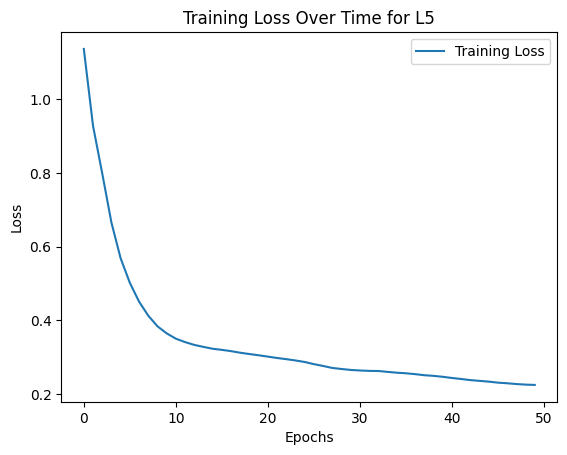

9330/9330 [==============================] - 15s 2ms/step


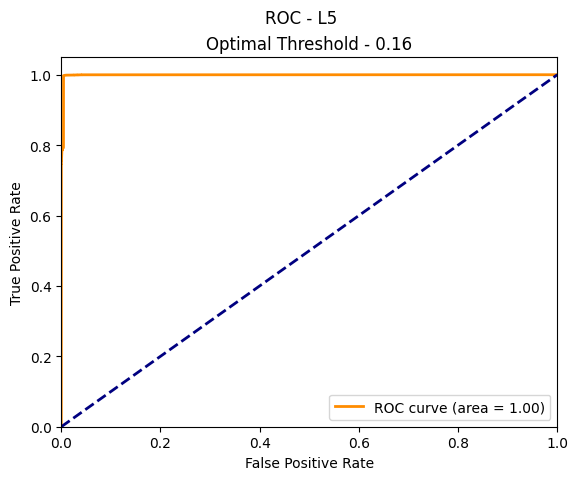

21501/21501 [==============================] - 33s 2ms/step
Epoch 1/50
124/124 [==============================] - 1s 2ms/step - loss: 1.1350
Epoch 2/50
124/124 [==============================] - 0s 2ms/step - loss: 0.9184
Epoch 3/50
124/124 [==============================] - 0s 2ms/step - loss: 0.7575
Epoch 4/50
124/124 [==============================] - 0s 2ms/step - loss: 0.6472
Epoch 5/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5745
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5176
Epoch 7/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4695
Epoch 8/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4283
Epoch 9/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3966
Epoch 10/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3724
Epoch 11/50
124/124 [==============================] - 1s 5ms/step - loss: 0.3497
Epoch 12/50
124/124 [==========================

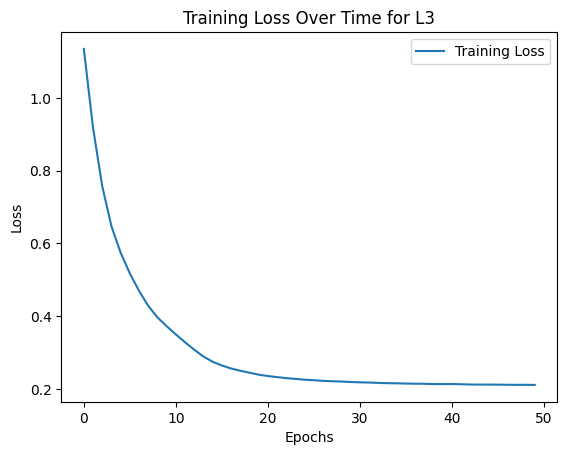

9330/9330 [==============================] - 15s 2ms/step


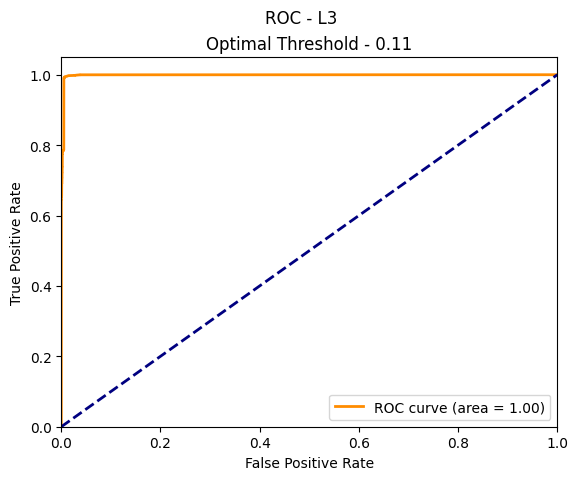

21501/21501 [==============================] - 33s 2ms/step
Epoch 1/50
124/124 [==============================] - 1s 2ms/step - loss: 0.9786
Epoch 2/50
124/124 [==============================] - 0s 2ms/step - loss: 0.8037
Epoch 3/50
124/124 [==============================] - 0s 2ms/step - loss: 0.6317
Epoch 4/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5092
Epoch 5/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4266
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3780
Epoch 7/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3533
Epoch 8/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3387
Epoch 9/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3297
Epoch 10/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3236
Epoch 11/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3189
Epoch 12/50
124/124 [==========================

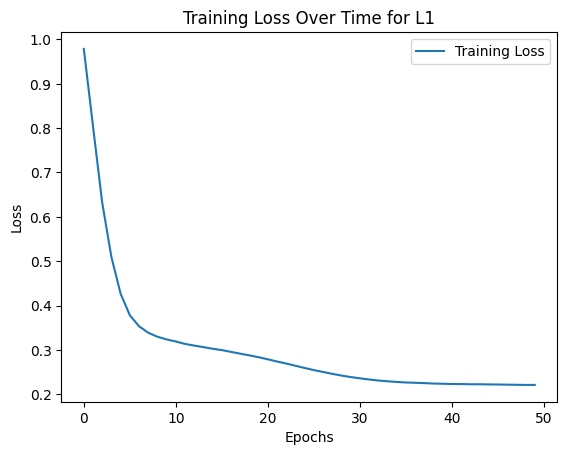

9330/9330 [==============================] - 15s 2ms/step


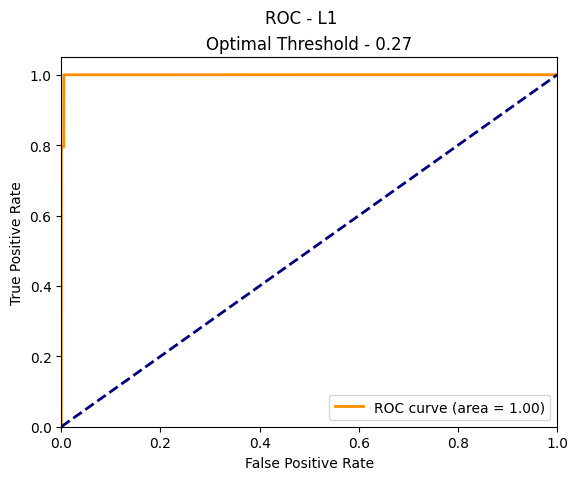

21501/21501 [==============================] - 36s 2ms/step
Epoch 1/50
124/124 [==============================] - 1s 2ms/step - loss: 1.0419
Epoch 2/50
124/124 [==============================] - 0s 3ms/step - loss: 0.7849
Epoch 3/50
124/124 [==============================] - 0s 3ms/step - loss: 0.6663
Epoch 4/50
124/124 [==============================] - 0s 3ms/step - loss: 0.5817
Epoch 5/50
124/124 [==============================] - 0s 3ms/step - loss: 0.5063
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4524
Epoch 7/50
124/124 [==============================] - 0s 3ms/step - loss: 0.4130
Epoch 8/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3793
Epoch 9/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3478
Epoch 10/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3205
Epoch 11/50
124/124 [==============================] - 0s 3ms/step - loss: 0.3003
Epoch 12/50
124/124 [==========================

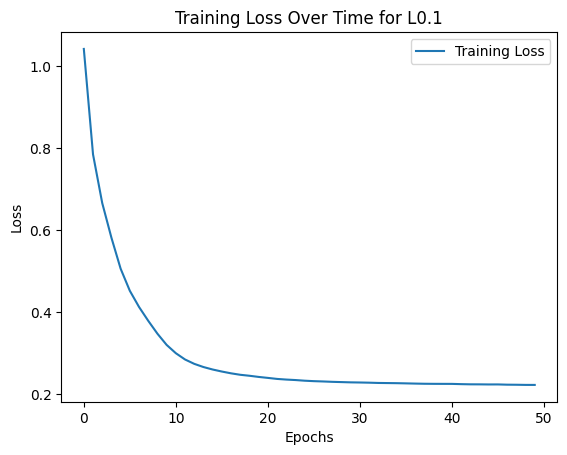

9330/9330 [==============================] - 15s 2ms/step


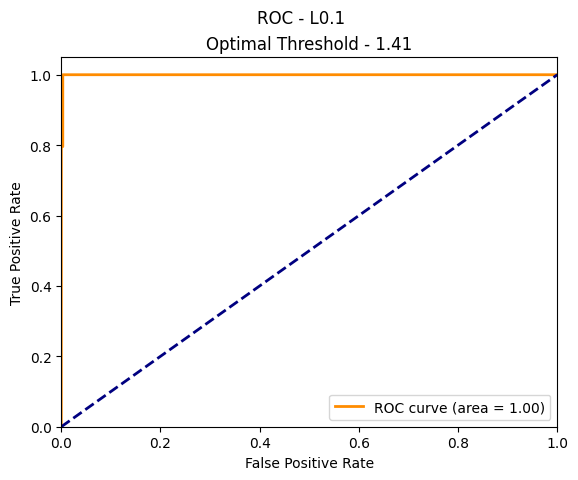

21501/21501 [==============================] - 33s 2ms/step
Epoch 1/50
124/124 [==============================] - 1s 2ms/step - loss: 0.9444
Epoch 2/50
124/124 [==============================] - 0s 2ms/step - loss: 0.7440
Epoch 3/50
124/124 [==============================] - 0s 2ms/step - loss: 0.6296
Epoch 4/50
124/124 [==============================] - 0s 2ms/step - loss: 0.5516
Epoch 5/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4965
Epoch 6/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4518
Epoch 7/50
124/124 [==============================] - 0s 2ms/step - loss: 0.4131
Epoch 8/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3816
Epoch 9/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3565
Epoch 10/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3359
Epoch 11/50
124/124 [==============================] - 0s 2ms/step - loss: 0.3204
Epoch 12/50
124/124 [==========================

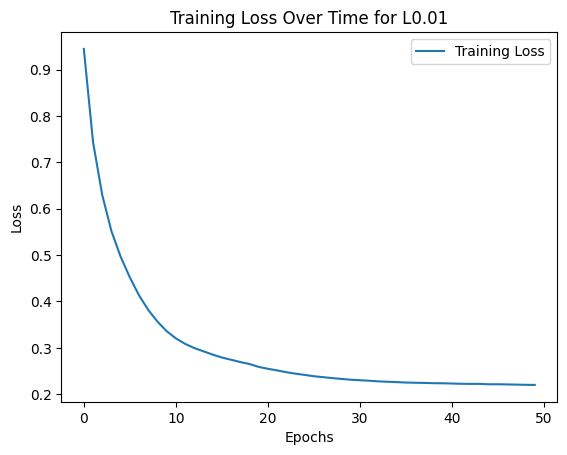

9330/9330 [==============================] - 16s 2ms/step


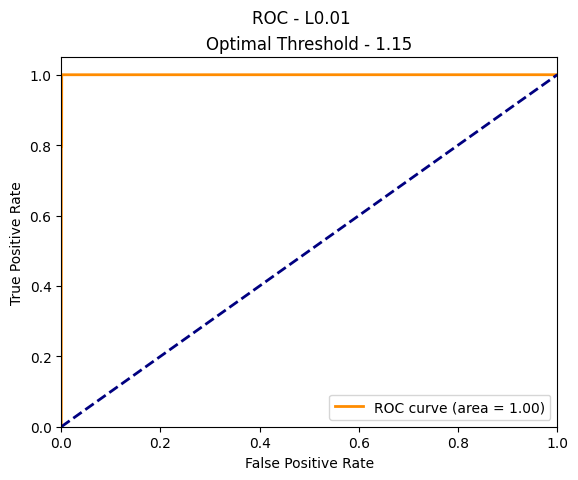

21501/21501 [==============================] - 35s 2ms/step


In [ ]:
autoencoders = {}
predictions = {}

for time in times:
  autoencoder = Autoencoder(time)
  autoencoders[time] = autoencoder
  autoencoder.fit(X_train[time])
  predictions[time] = autoencoder.predict(X_test[time], autoencoder.compute_threshold(X_val[time], Y_val))

In [ ]:
tot = np.zeros(len(Y_test))

for time in times:
  tot += predictions[time]

majority_votes = (tot < len(times)/2).astype(int)

In [ ]:
confusion_matrix(Y_test, majority_votes)

array([[  9401,    509],
       [     0, 678120]])

In [ ]:
print(classification_report(Y_test, majority_votes))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      9910
           1       1.00      1.00      1.00    678120

    accuracy                           1.00    688030
   macro avg       1.00      0.97      0.99    688030
weighted avg       1.00      1.00      1.00    688030

